In [20]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
matplotlib.rcParams.update({'font.size': 18})

In [38]:
classifier = True

In [39]:
if classifier:
    df = pd.read_pickle("data/Mnist_Class_data")
else:
    df = pd.read_pickle("data/Mnist_AE_5")
# read targets and conditions from dataframe
train_data, train_targets = (
    torch.from_numpy(df["train_x"]),
    torch.from_numpy(df["train_y"]),
)

center = torch.mean(train_targets)
std = torch.std(train_targets)

In [40]:
if classifier:
    GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/classifier/version_4/checkpoints/last.ckpt"
    )
else:
    GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "lightning_logs/Autoencoder5/version_1/checkpoints/last.ckpt"
    )
GT.eval()

torch.Size([60000, 1, 8, 8])
cond_dim:  0
latent_dim:  10
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]


FreeFormInjectiveFlow(
  (cross_entropy): CrossEntropyLoss()
  (models): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (model): Sequential(
        (encoder): Sequential(
          (0): Unflatten(dim=-1, unflattened_size=(1, 8, 8))
          (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (4): ReLU()
          (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (6): ReLU()
          (7): Flatten(start_dim=-3, end_dim=-1)
          (8): Linear(in_features=1024, out_features=10, bias=True)
        )
        (decoder): Sequential(
          (0): Linear(in_features=10, out_features=4096, bias=True)
          (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
          (2): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
          (3): Sigmoid()
          (4): Flatten(

In [57]:
if classifier:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/class_e5newe3_long/version_0/checkpoints/last.ckpt"
    )
else:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/ae5_e5newe3/version_0/checkpoints/last.ckpt"
    )

cond_dim:  10
latent_dim:  54
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
Teacher is Classifier
torch.Size([60000, 1, 8, 8])
cond_dim:  0
latent_dim:  10
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]


In [58]:
torch.set_grad_enabled(False)

encoding...
reconstructing...
sampling...


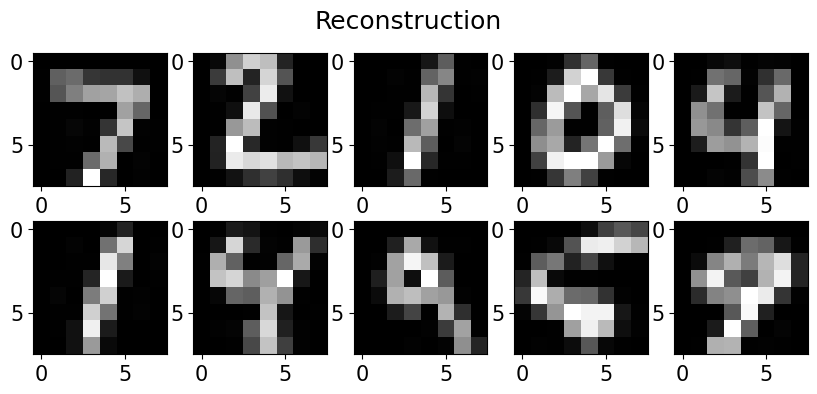

[1.0994594e-07 1.2797661e-07 4.1749850e-08 5.6624412e-08 4.0039506e-08
 7.5055127e-08 7.5217663e-08 4.6265647e-08 1.1774746e-07 1.3943539e-07]
main detail standard deviation:  tensor(0.2828)


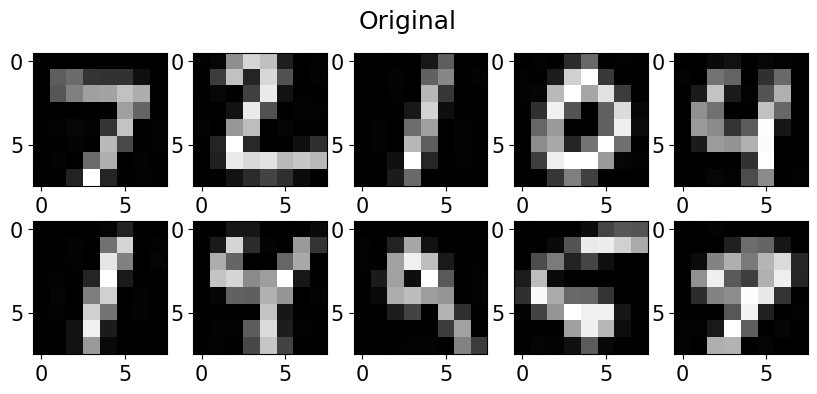

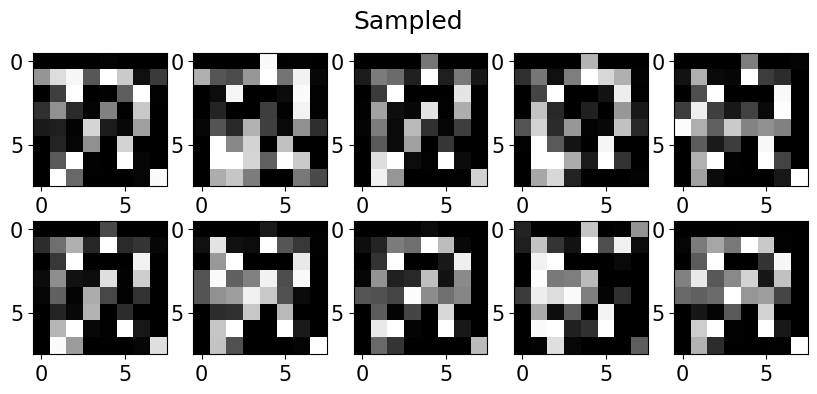

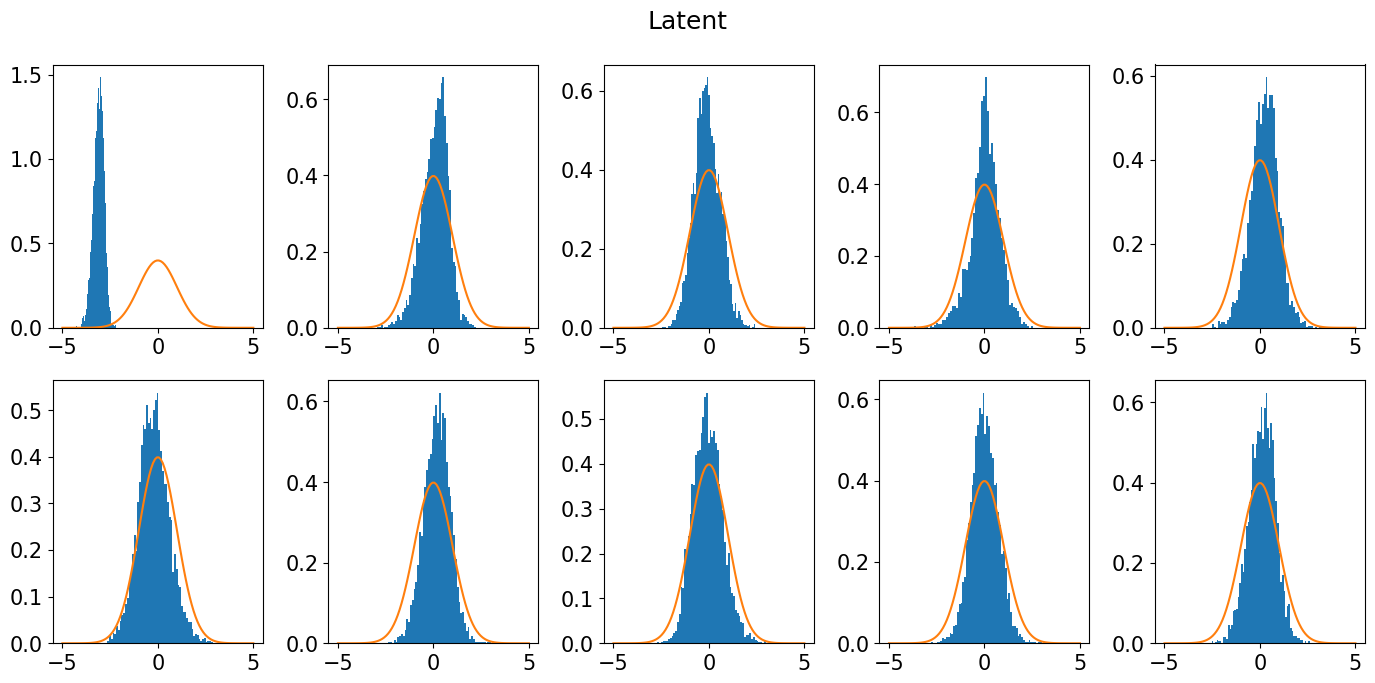

In [59]:
data = plot_mnist(model)
z_test = data["test_z"]
std_z0 = torch.std(z_test[:,0])
print("main detail standard deviation: ", std_z0)
latent_dim = data["test_c"].shape[1]

/tmp/ipykernel_3020131/3014672490.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[6,5])


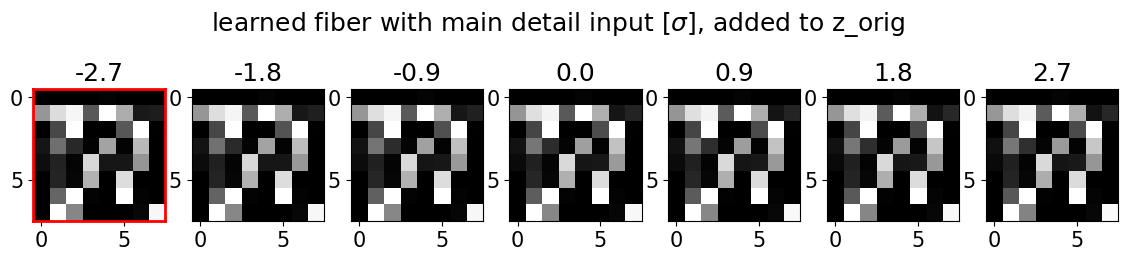

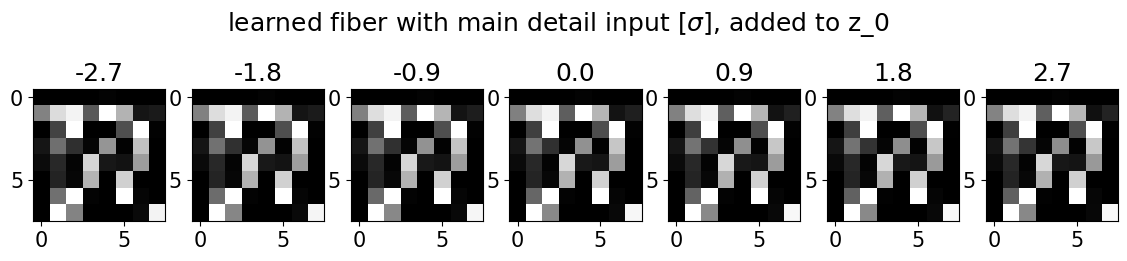

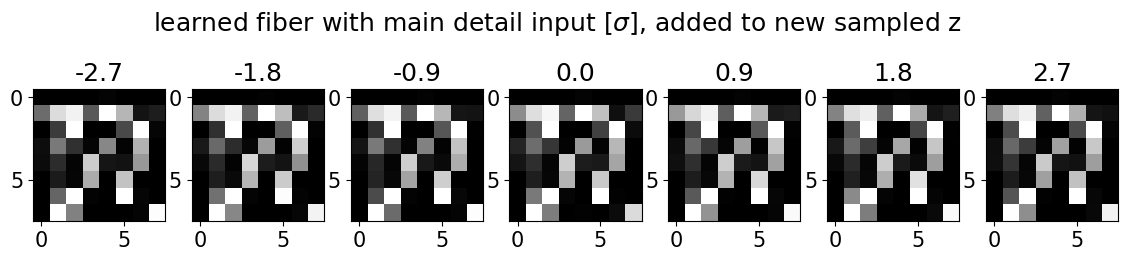

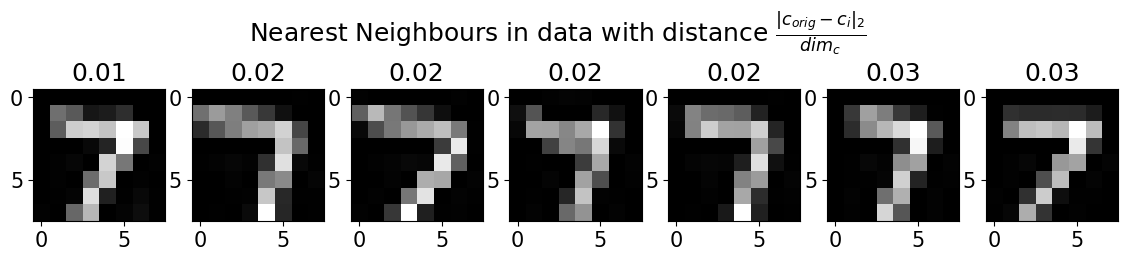

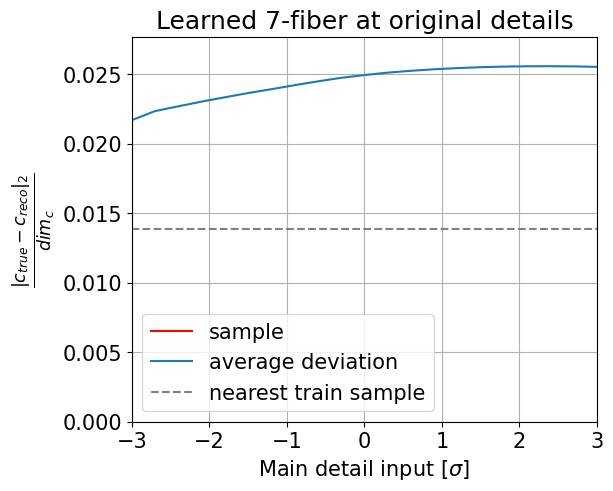

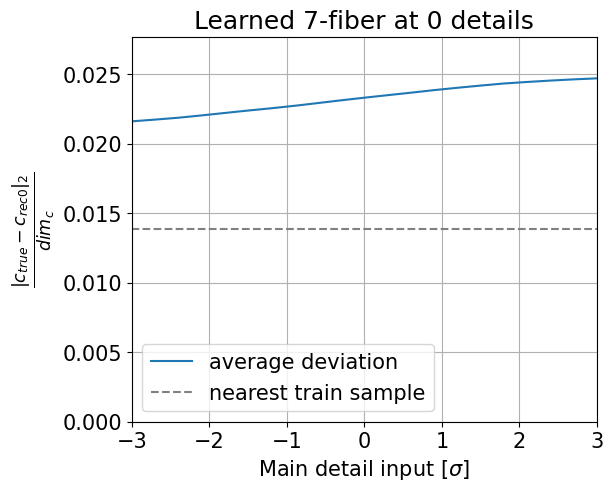

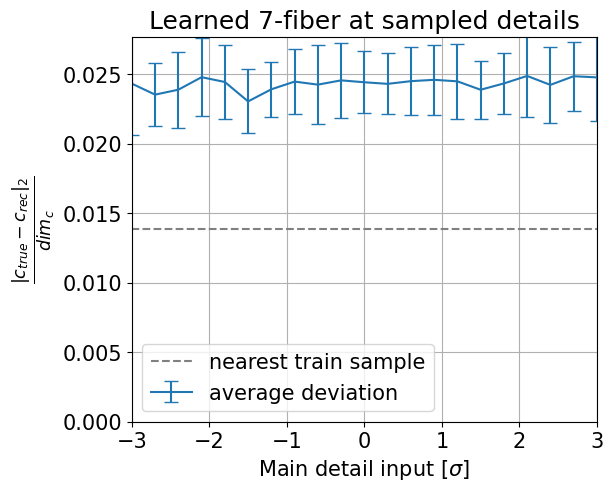

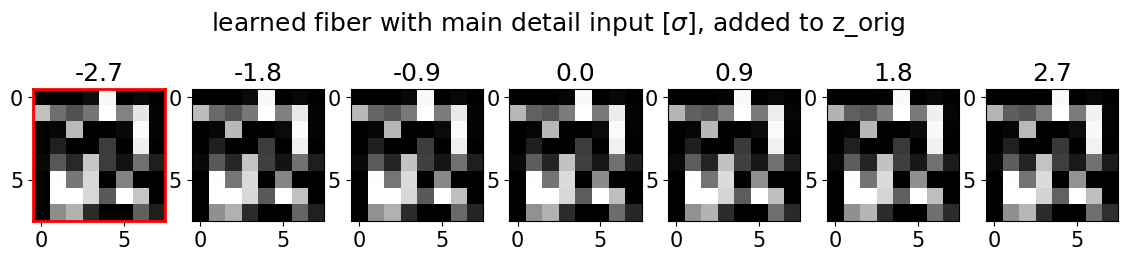

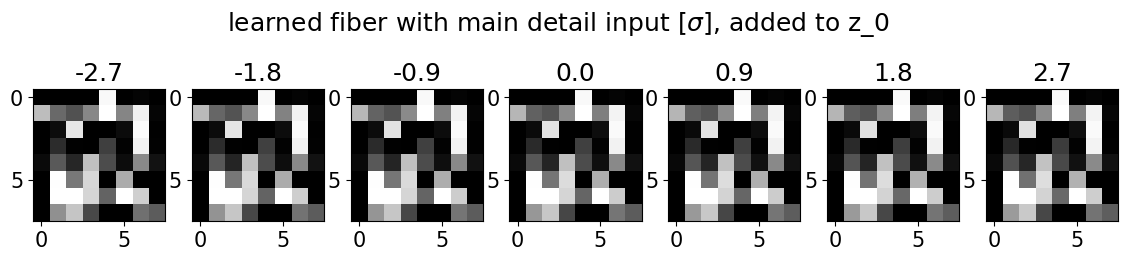

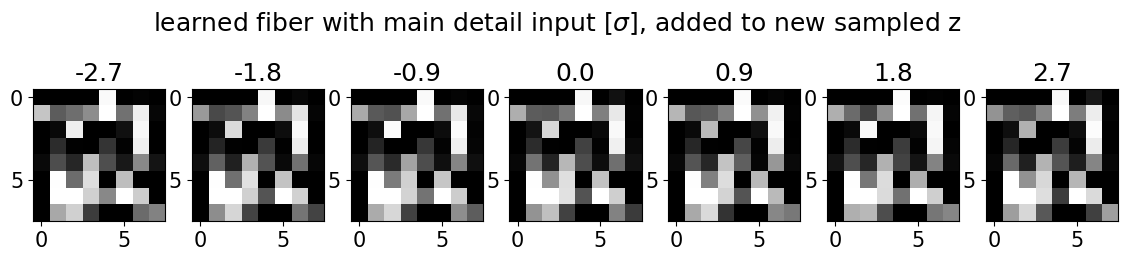

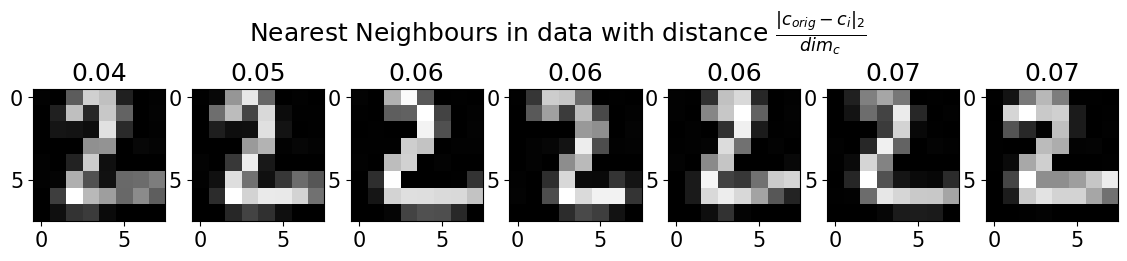

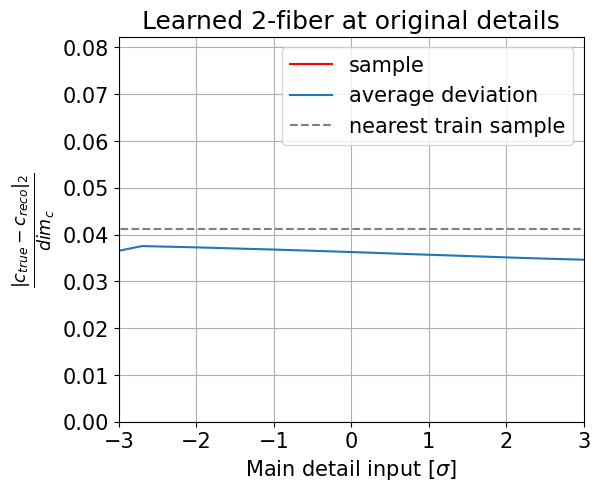

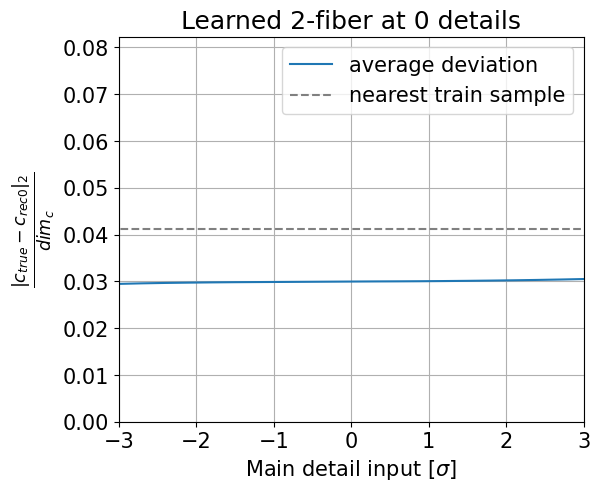

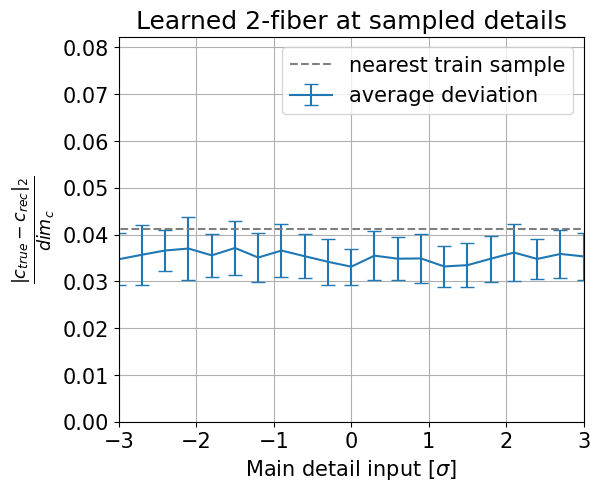

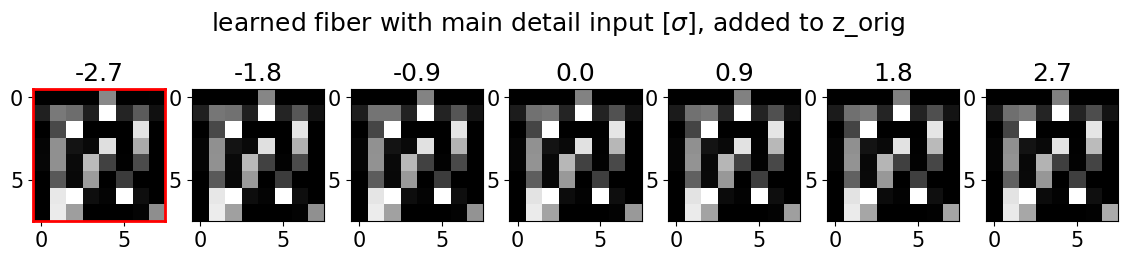

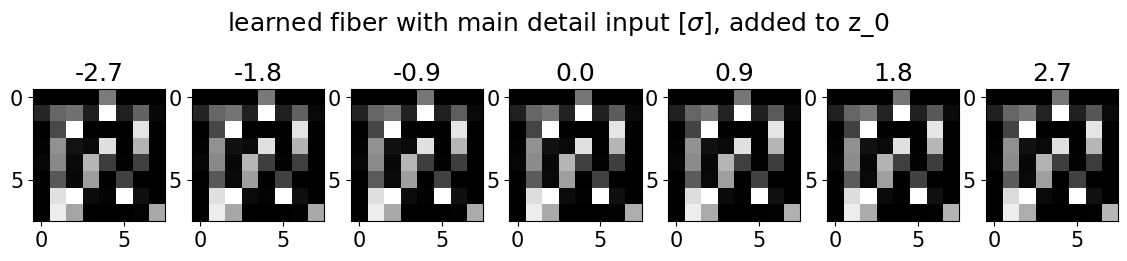

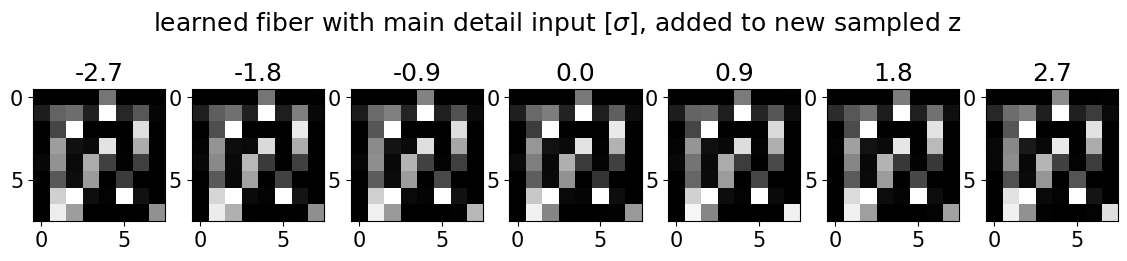

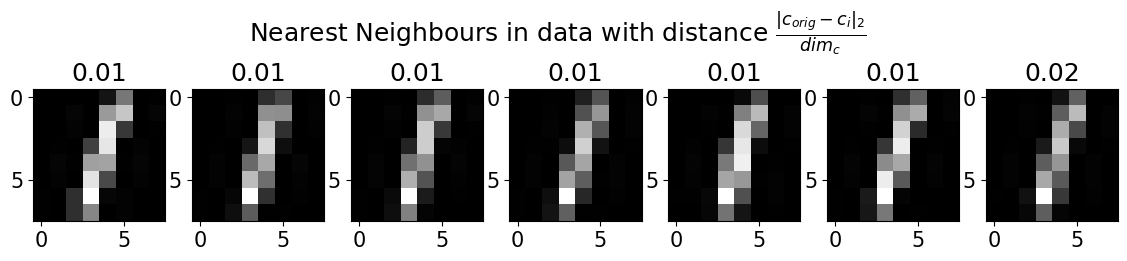

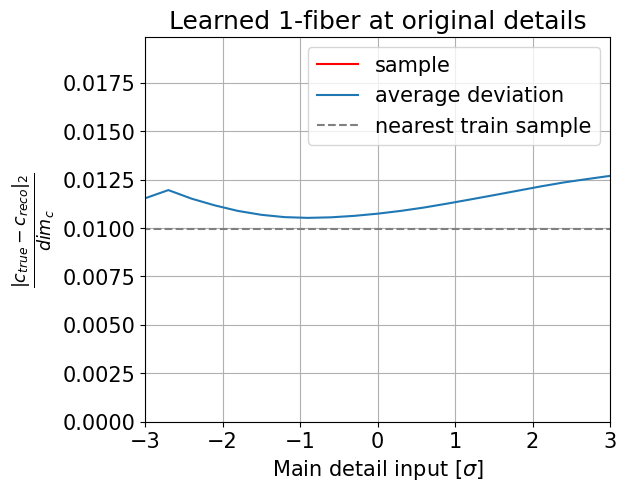

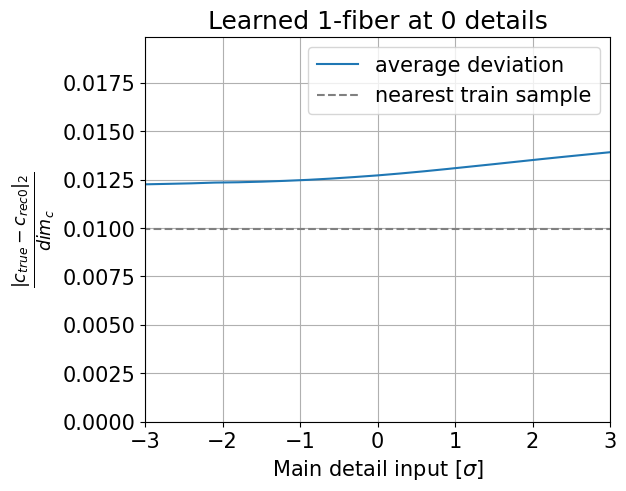

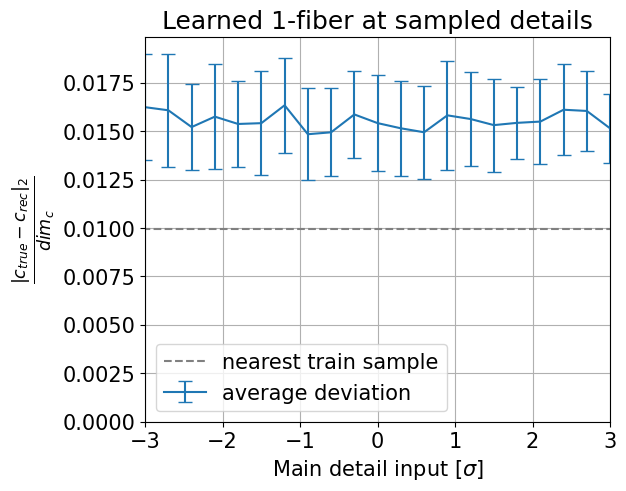

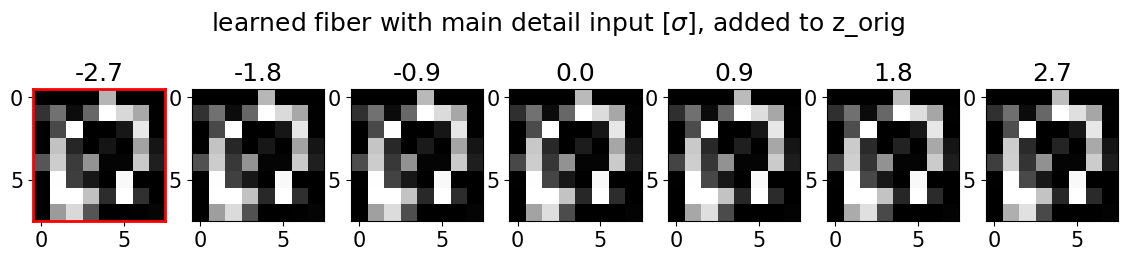

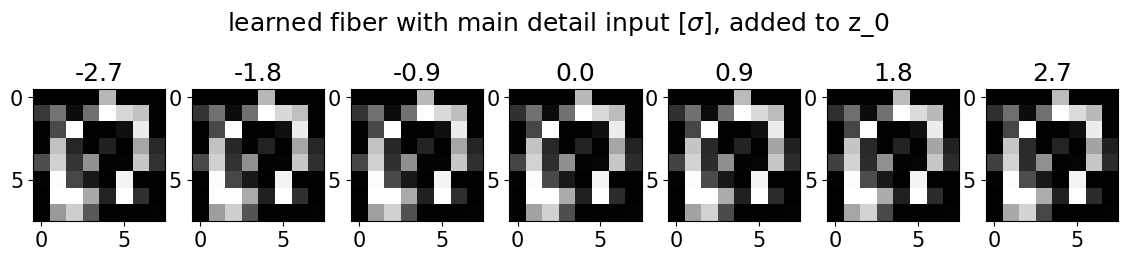

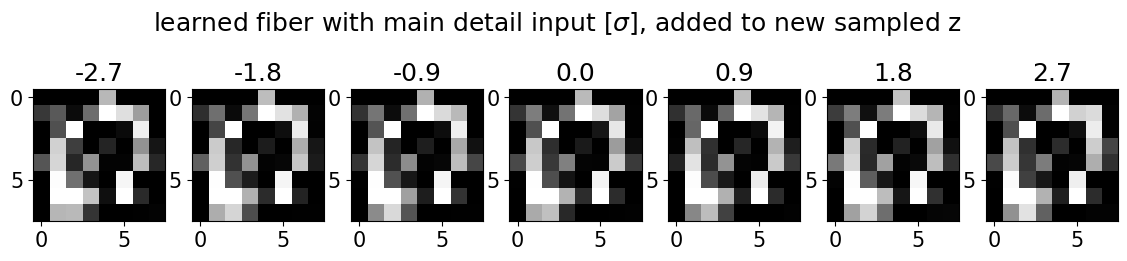

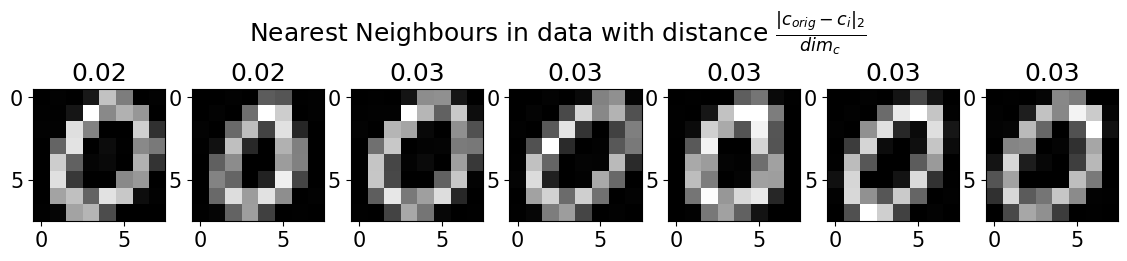

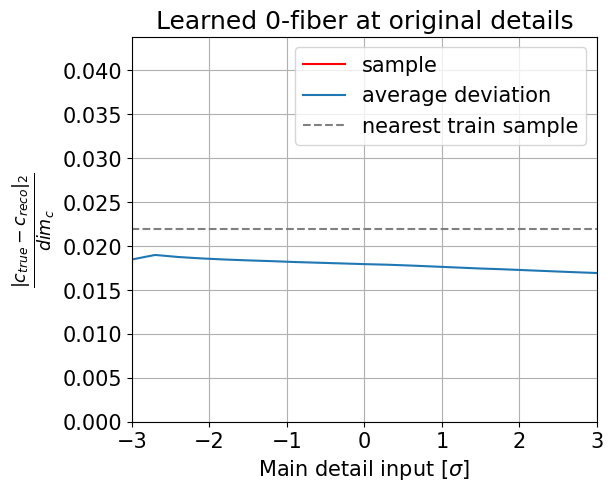

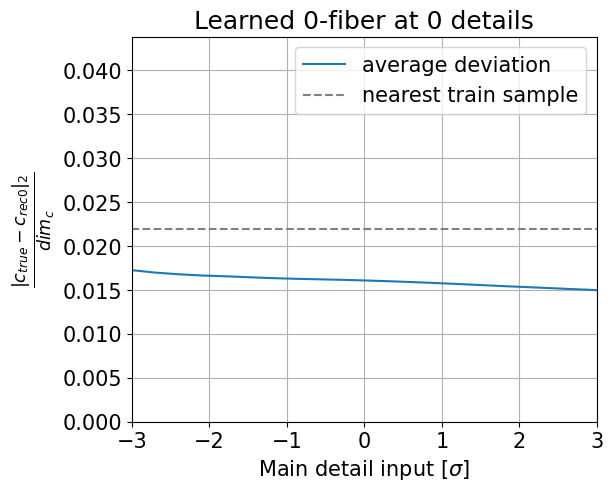

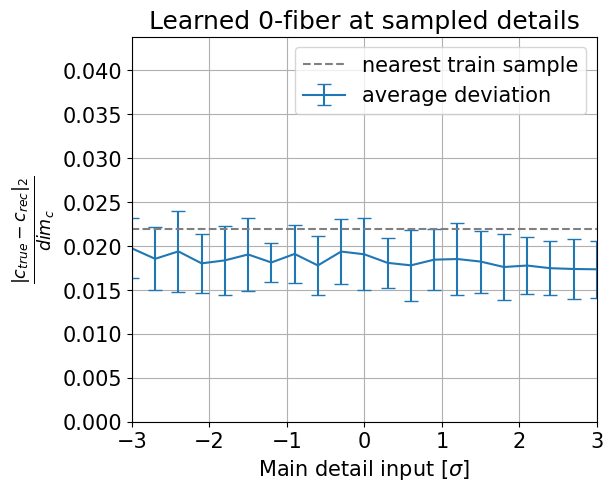

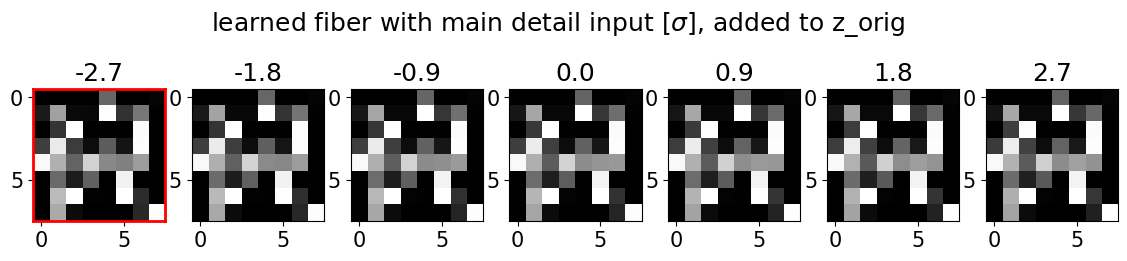

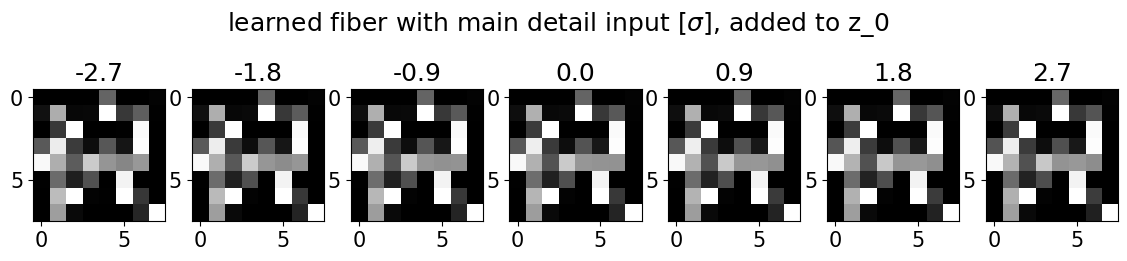

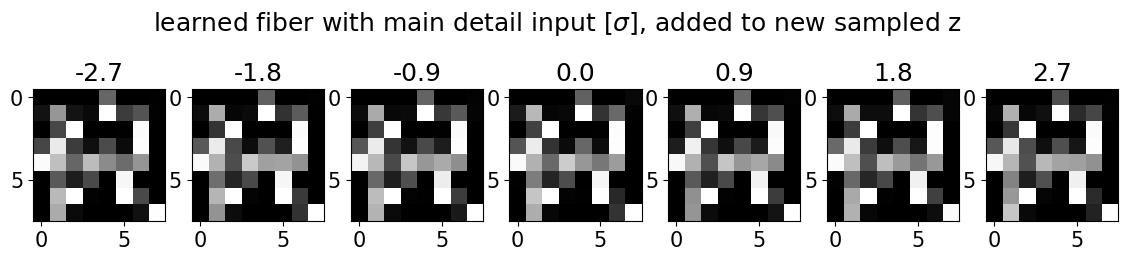

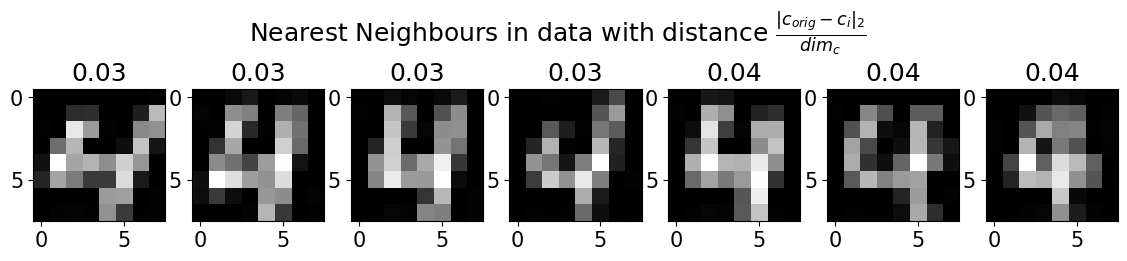

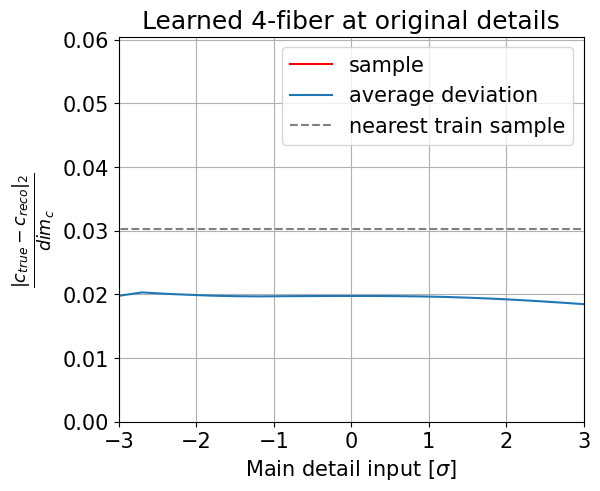

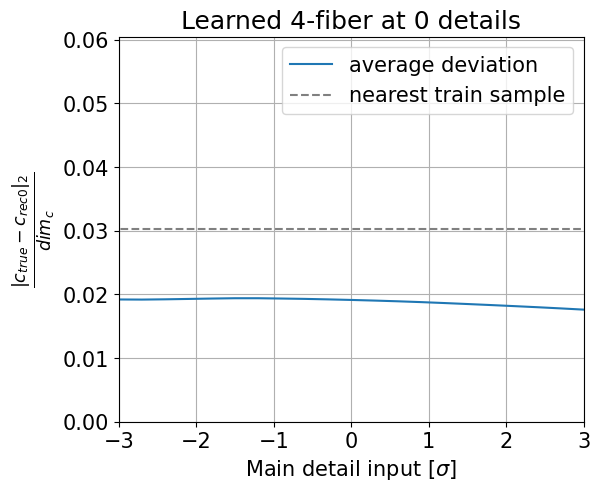

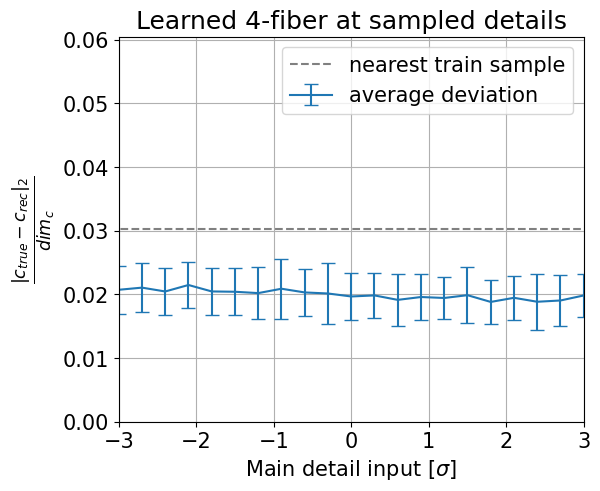

In [60]:
zrange = 3*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4]

for j in range(5):
    xs, c_sample, z0_range, NN, z0_sample = plot_details(model, data, j, zrange)
    for i, xi in enumerate(xs):
        if classifier == False:
            conditioned = GT.apply_conditions((xi,))
            c = conditioned.condition
            x = conditioned.x0
            check_fiber = (GT.encode(x.to(GT.device), c.to(GT.device)).cpu() - center) / std
        else:
            conditioned = GT.apply_conditions((xi,c_sample))
            x = conditioned.x0
            c = torch.empty((x.shape[0], 0), device=x.device, dtype=x.dtype)
            check_fiber = (Features.encode(x.to(GT.device), c.to(GT.device)).cpu() - center) / std
        
        #print(torch.max(check_fiber-c_sample, dim=1)[0])
                
        plt.figure(figsize=[6,5])
        if i == 0:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample)**2, dim=1)).numpy()/latent_dim
            delta_details = z0_range/std_z0
            plt.axvline(x=z0_sample/std_z0, ymin=0, ymax=2,color='red', label='sample')
            plt.plot(delta_details,delta_coarse, label="average deviation")
        elif i==1:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample)**2, dim=1)).numpy()/latent_dim
            delta_details = np.linspace(-zrange,zrange,z0_range.shape[0])/std_z0
            plt.plot(delta_details,delta_coarse, label="average deviation")
        else:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample.repeat(40,1))**2, dim=1))/latent_dim
            delta_c_std, delta_coarse = torch.std_mean(delta_coarse.reshape(40,-1), dim=0)
            delta_coarse = delta_coarse.numpy()
            delta_details = np.linspace(-zrange,zrange,z0_range.shape[0])/std_z0
            plt.errorbar(delta_details,delta_coarse,yerr=delta_c_std, label="average deviation",capsize=5)
            
        #plotting...
        plt.axhline(y=NN, xmin=-10, xmax=10, color='gray', linestyle="--", label='nearest train sample')
        if i == 0:
            plt.title(f"Learned {nums[j]}-fiber at original details")
            plt.ylabel(r"$\frac{|c_{true}-c_{reco}|_2}{dim_c}$", fontsize=18)
        elif i==1:
            plt.title(f"Learned {nums[j]}-fiber at 0 details")
            plt.ylabel(r"$\frac{|c_{true}-c_{rec0}|_2}{dim_c}$", fontsize=18)
        else:
            plt.title(f"Learned {nums[j]}-fiber at sampled details")
            plt.ylabel(r"$\frac{|c_{true}-c_{rec}|_2}{dim_c}$", fontsize=18)
        plt.legend()
        plt.xlabel(r"Main detail input [$\sigma$]")
        plt.ylim((0,2*NN))
        plt.xlim((-zrange/std_z0,zrange/std_z0))
        plt.grid()
        #plt.savefig(f"plots/class_norm/{1-i}deviation{nums[j]}.png")

In [49]:
def plot_details(model2plot, data, sample, zrange):
    device = model2plot.device
    pos_min, pos_max = -zrange, zrange
    c = data["test_c"]
    z = data["test_z"]
    train_c = data["train_c"]
    train_samples = data["train_samples"]
    N = 21
    n = 7

    #calculate two walks along main detail dimension
    z0_range = torch.linspace(pos_min, pos_max, N)
    z0_range1 = z0_range.clone()
    z0_range1[torch.argmin((z0_range-z[sample][0])**2)] = z[sample][0]
    z0_sample = z[sample][0].numpy()
    
    z_list = []
    for i in range(N):
        z_new = z[sample].clone()
        z_new[0] = z0_range1[i]
        z_list.append(z_new)
    new_details1 = torch.stack(z_list)

    new_details0 = torch.zeros(N,53)
    new_details0 = torch.cat([torch.unsqueeze(z0_range,1), new_details0], dim=1)
    
    new_details_norm = torch.randn(40,N,53)
    z0_range_norm = torch.unsqueeze(z0_range,0)
    z0_range_norm = z0_range_norm.repeat(40,1)
    new_details_norm = torch.cat([torch.unsqueeze(z0_range_norm,2), new_details_norm], dim=2)
    new_details_norm = torch.reshape(new_details_norm, (40*N,54))
    
    #decoding...
    c_sample = torch.unsqueeze(c[sample], dim=0)
    c_sample_norm = c_sample.repeat(40*N,1)
    c_sample = c_sample.repeat(N,1)
    x_details1 = model2plot.decode(new_details1.to(device), c_sample.to(device)).cpu()
    x_details_norm = model2plot.decode(new_details_norm.to(device), c_sample_norm.to(device)).cpu()
    x_details0 = model2plot.decode(new_details0.to(device), c_sample.to(device)).cpu()

    #plotting...
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    del_detail = []
    for i in range(n):
        axes[i].imshow(x_details1[i*N//n+1].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title((z0_range1[i*N//n+1]/std_z0).numpy().round(1))
        del_detail.append(z0_range1[i*N//n+1])
    del_detail = (np.array(del_detail)-z0_sample)**2
    closest = np.argmin(del_detail)
    for spine in axes[closest].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)
    plt.suptitle(r"learned fiber with main detail input [$\sigma$], added to z_orig")

    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details0[i*N//n+1].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title((z0_range[i*N//n+1]/std_z0).numpy().round(1))
    plt.suptitle(r"learned fiber with main detail input [$\sigma$], added to z_0")
    
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details_norm[i*N*40//n+40].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title((z0_range[i*N//n+1]/std_z0).numpy().round(1))
    plt.suptitle(r"learned fiber with main detail input [$\sigma$], added to new sampled z")

    verify = c[sample]
    diff = train_c - verify
    squared_diff = torch.sqrt(torch.sum(torch.square(diff), dim =1))
    ind = torch.argsort(squared_diff)[:n]
    #print("squared distance between chosen sample and nearest train samples:", squared_diff[ind]/5)
    similar = train_samples[ind]
    NN = squared_diff[ind[0]].numpy()/latent_dim

    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(similar[i].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title(np.round(squared_diff[ind[i]].numpy()/latent_dim,2))
    fig.suptitle(r"Nearest Neighbours in data with distance $\frac{|c_{orig}-c_i|_2}{dim_c}$")
    
    return [x_details1, x_details0, x_details_norm], c_sample, z0_range1, NN, z0_sample

In [55]:
from fff.evaluate.plots import all_conditions
def plot_mnist(model2plt):
    device = model2plt.device
    
    data = {}
    train_batch = model2plt.train_data[:]
    test_batch = model2plt.test_data[:5000]

    train_conditioned = model2plt.apply_conditions(train_batch)
    train_samples = train_conditioned.x0
    train_c = train_conditioned.condition
    
    test_conditioned = model2plt.apply_conditions(test_batch)
    test_c = test_conditioned.condition
    test_samples = test_conditioned.x0
    
    data["train_samples"] = train_samples
    data["test_c"] = test_c
    data["train_c"] = train_c

    #computing...
    print("encoding...")
    batch_size = model2plt.hparams.batch_size
    test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), test_c.split(batch_size))
    ])
    data["test_z"] = test_z
    
    print("reconstructing...")
    reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_z.split(batch_size), test_c.split(batch_size))
    ])
   
    print("sampling...") 
    z_sampled = torch.randn_like(test_z)
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), test_c.split(batch_size))
    ])

    #plotting...
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(reconstruction[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Reconstruction")
    plt.show()
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(test_samples[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Original")
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(x_sampled[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Sampled")

    #sanity check
    if classifier:
        conditioned = GT.apply_conditions((test_samples[:10],torch.zeros((10,0),device=device)))
        x_san = conditioned.x0
        c_emp = torch.empty((x_san.shape[0], 0), device=x_san.device, dtype=x_san.dtype)
        c_san = (Features.encode(x_san.to(GT.device), c_emp.to(GT.device)).cpu()-center)/std
    else:
        conditioned = GT.apply_conditions((test_samples[:10],))
        c_emp = conditioned.condition
        x_san = conditioned.x0
        c_san = (GT.encode(x_san.to(GT.device), c_emp.to(GT.device)).cpu()-center)/std
    sanity = torch.sqrt(torch.sum((c_san-test_c[:10])**2, dim=1)).numpy()/5
    print(sanity)

    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))
    a = np.linspace(-5,5,100)
    for i in range(2):
        for j in range(5):
            axes[i][j].hist(test_z[:,i*5+j], bins=60, label="Samples", density=True)
            axes[i][j].plot(a, normal(a))
    fig.suptitle("Latent")
    fig.tight_layout()

    return data

In [30]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [5]:
Classifier = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/classifier/version_4/checkpoints/last.ckpt"
    )

torch.Size([60000, 1, 8, 8])
cond_dim:  0
latent_dim:  10
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]


In [10]:
z = (torch.from_numpy(df["val_y"]) - center) / std
val_data = Classifier.val_data[:]
conditioned = Classifier.apply_conditions(val_data)
t = conditioned.condition
y = np.argmax(t,axis=1)
reducer = umap.UMAP()
embedding = reducer.fit_transform(z)
print(embedding.shape)

(10000, 2)


<Figure size 800x500 with 0 Axes>

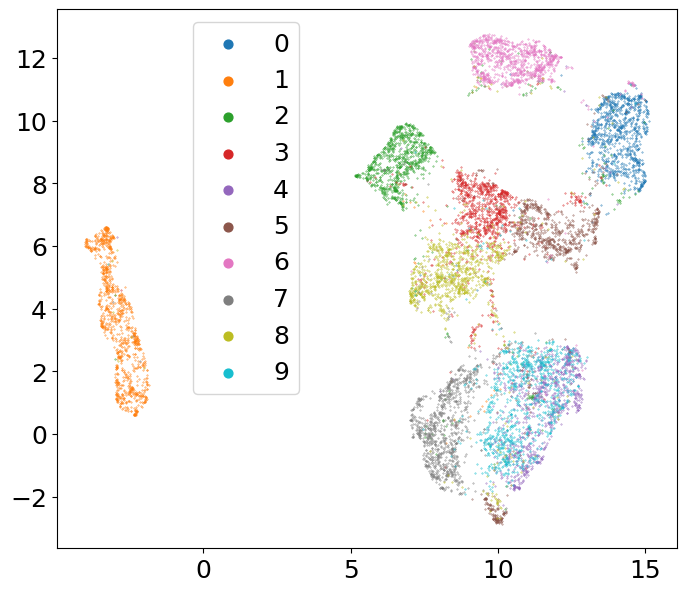

In [16]:
plt.figure(figsize=[8,7])
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.legend(markerscale=20.,loc='upper left',bbox_to_anchor=(0.2, 1.))

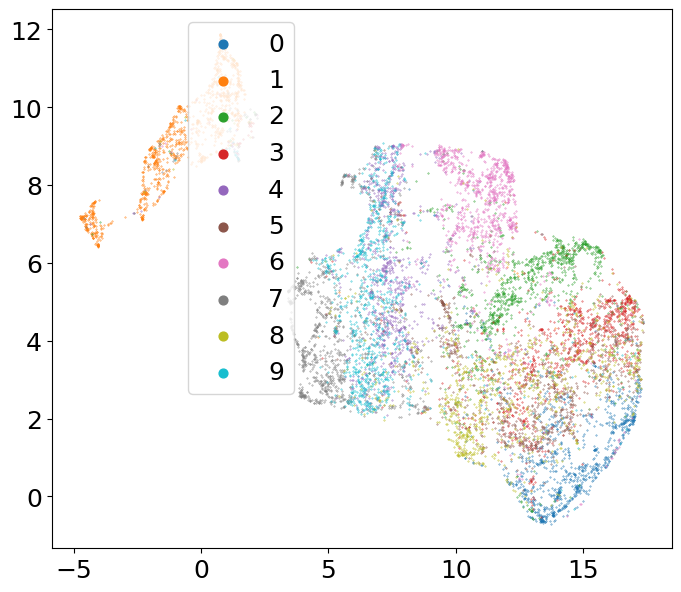

In [19]:
plt.figure(figsize=[8,7])
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.legend(markerscale=20.,loc='upper left',bbox_to_anchor=(0.2, 1.))

torch.Size([10000, 10])
torch.Size([10000])


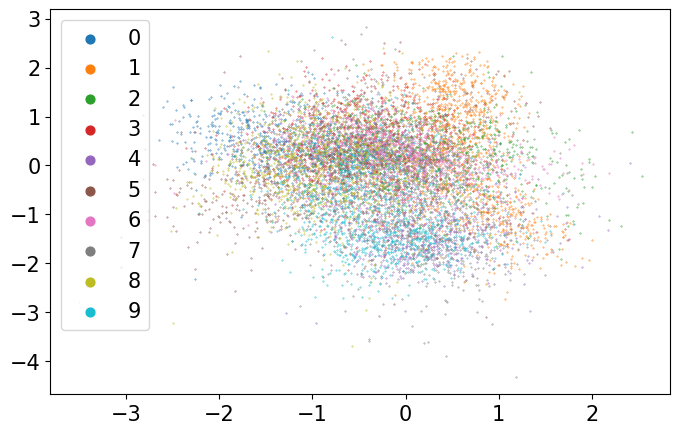

In [30]:
plt.figure(figsize=[8,5])
z = (torch.from_numpy(df["val_y"]) - center) / std
val_data = Classifier.val_data[:]
conditioned = Classifier.apply_conditions(val_data)
t = conditioned.condition
y = np.argmax(t,axis=1)
print(z.shape)
z0 = z[:,6]
z1 = z[:,7]
print(y.shape)
for i in range(10):
    z0i = z0[y==i]
    z1i = z1[y==i]
    plt.scatter(z0i,z1i, s=0.1, label=i)
plt.legend(markerscale=20.)

In [44]:
from fff.model.utils import guess_image_shape
class Truncate(torch.nn.Module):
            def __init__(self):
                super(Truncate, self).__init__()
                enc_conv = list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[0]
                enc_res = list(
                    list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[:-2]
                self.features = torch.nn.Sequential(
                    enc_conv, *enc_res
                )

            def cat_x_c(self, x, c):
                # Reshape as image, and concatenate conditioning as channel dimensions
                has_batch_dimension = len(x.shape) > 1
                if not has_batch_dimension:
                    x = x[None, :]
                    c = c[None, :]
                batch_size = x.shape[0]
                input_shape = guess_image_shape(GT.data_dim)
                x_img = x.reshape(batch_size, *input_shape)
                c_img = c[:, :, None, None] * torch.ones(batch_size, GT.cond_dim, *input_shape[1:], device=c.device)
                out = torch.cat([x_img, c_img], -3).reshape(batch_size, -1)
                if not has_batch_dimension:
                    out = out[0]
                return out
            
            def encode(self, x, c):
                x = self.features(self.cat_x_c(x,c))
                return x

Features = Truncate()

In [7]:
save_data(GT)

encoding traindata...
encoding valdata...
encoding testdata...


In [4]:
def save_data(rectangular_flow):
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x_noisy
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x_noisy
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x_noisy
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    path = "data/"
    fileName = path + 'Mnist_AE_5'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()